In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

from tsfresh.feature_extraction import extract_features
from tsfresh import select_features
from datetime import timedelta
from tsfresh.utilities.dataframe_functions import impute
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from sklearn.model_selection import TimeSeriesSplit
import pmdarima as pm
import matplotlib.pyplot as plt

In [2]:
# database simulation
label = pd.read_pickle('label.pkl')
model = auto_arima(label, max_p=8, max_q=8, max_order=None, \
                seasonal=True, m=3, \
                trace=True, error_action="ignore", suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[3] intercept   : AIC=572921.335, Time=149.48 sec
 ARIMA(0,1,0)(0,0,0)[3] intercept   : AIC=589035.425, Time=3.18 sec
 ARIMA(1,1,0)(1,0,0)[3] intercept   : AIC=574520.323, Time=21.76 sec
 ARIMA(0,1,1)(0,0,1)[3] intercept   : AIC=575045.811, Time=22.14 sec
 ARIMA(0,1,0)(0,0,0)[3]             : AIC=589033.426, Time=1.22 sec
 ARIMA(2,1,2)(0,0,1)[3] intercept   : AIC=565563.148, Time=193.70 sec
 ARIMA(2,1,2)(0,0,0)[3] intercept   : AIC=565561.457, Time=78.14 sec
 ARIMA(2,1,2)(1,0,0)[3] intercept   : AIC=565563.152, Time=116.44 sec
 ARIMA(1,1,2)(0,0,0)[3] intercept   : AIC=inf, Time=73.65 sec
 ARIMA(2,1,1)(0,0,0)[3] intercept   : AIC=566263.716, Time=59.88 sec
 ARIMA(1,1,1)(0,0,0)[3] intercept   : AIC=574883.073, Time=11.08 sec
 ARIMA(2,1,2)(0,0,0)[3]             : AIC=565559.461, Time=32.86 sec
 ARIMA(2,1,2)(1,0,0)[3]             : AIC=565561.156, Time=57.07 sec
 ARIMA(2,1,2)(0,0,1)[3]             : AIC=565561.151, Time=67.40 s

In [3]:
predict = model.predict_in_sample()

<AxesSubplot:xlabel='date'>

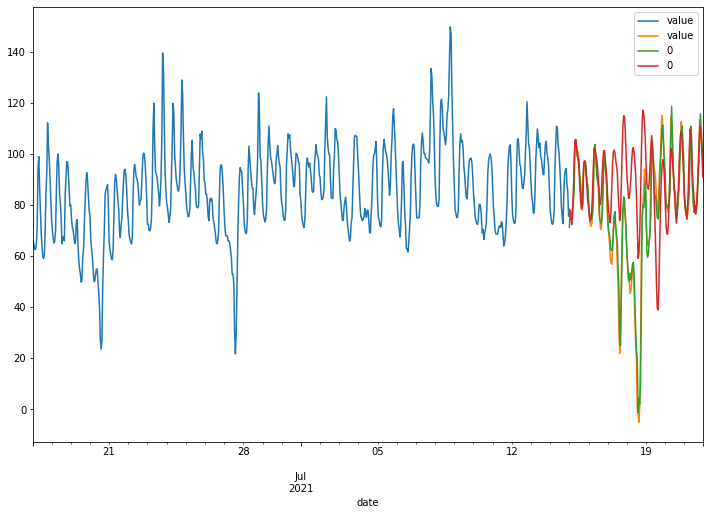

In [67]:
prediction_date = '2021-07-15 00:00:00'
prediction_length = 24*7
training_length = prediction_length*4
label_index = label.index.get_loc(prediction_date)
train_label = label.iloc[label_index+1-training_length:label_index+1]
test_label = label.iloc[label_index:label_index+prediction_length]
test_prediction = pd.DataFrame(predict[label_index:label_index+prediction_length], index=test_label.index)
# visualization
fig, ax = plt.subplots(1,1,figsize=(12,8))
train_label.plot(ax=ax)
test_label.plot(ax=ax)
test_prediction.plot(ax=ax)

features = pd.read_pickle('2021_features.pkl')
feature_index = features.index.get_loc(prediction_date)
train_features = features.iloc[feature_index+1-24*7*4*2:feature_index+1]
test_features = features.iloc[feature_index:feature_index+prediction_length]
feature_names = [
    'value__cwt_coefficients__coeff_2__w_2__widths_(2, 5, 10, 20)',
    'value__root_mean_square',
    'value__change_quantiles__f_agg_"mean"__isabs_False__qh_1.0__ql_0.0',
    'value__energy_ratio_by_chunks__num_segments_10__segment_focus_9',
    'value__mean_second_derivative_central',
    'value__fft_coefficient__attr_"imag"__coeff_3',
    'value__cwt_coefficients__coeff_0__w_10__widths_(2, 5, 10, 20)',
    'value__quantile__q_0.8', 'value__index_mass_quantile__q_0.9',
    'value__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.0',
    'value__mean_change', 'value__fft_coefficient__attr_"real"__coeff_8',
    'value__fft_coefficient__attr_"real"__coeff_9',
    'value__fft_aggregated__aggtype_"centroid"',
    'value__fft_coefficient__attr_"real"__coeff_10',
    'value__fft_coefficient__attr_"real"__coeff_12',
    'value__fft_coefficient__attr_"real"__coeff_11'

]
train_X = StandardScaler().fit_transform(np.array(train_features[feature_names]))
test_X = StandardScaler().fit_transform(np.array(test_features[feature_names]))

pred_model = pm.ARIMA(order=(2,1,2))
pred_model.fit(label.iloc[label_index+1-24*7*4*2:label_index+1], X=train_X)
true_test = pd.DataFrame(pred_model.predict(n_periods=prediction_length, X=test_X), index=test_label.index)
true_test.plot(ax=ax)

In [68]:
import joblib
import pickle
# Serialize with Pickle
with open('ARIMA.pkl', 'wb') as pkl:
    pickle.dump(model, pkl)

In [82]:
sum(abs(np.array(label[0:168].value) - np.array(test_label.value)))

6563.670000000001

In [88]:
interation_label = label.loc['2021-01-01 00:00:00':'2021-08-01 23:00:00']
try_label = label.loc['2019-01-01 00:00:00':'2019-01-01 23:00:00']
best_mae = float('inf')
best_index = 0
for index in range(interation_label.shape[0]-try_label.shape[0]+1):
    mae = sum(abs(np.array(interation_label[index:index+try_label.shape[0]].value) - np.array(try_label.value)))
    if mae < best_mae:
        best_mae = mae
        best_index = index
best_match_label = interation_label[best_index:best_index+try_label.shape[0]]

<AxesSubplot:>

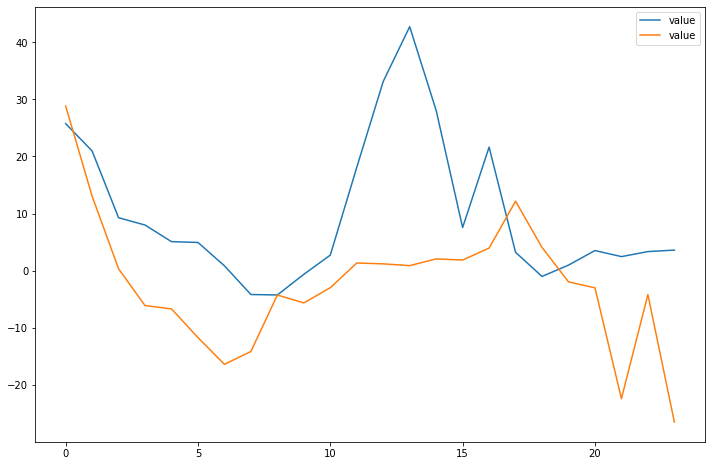

In [90]:
fig,ax = plt.subplots(1,1,figsize=(12,8))
best_match_label.reset_index(drop=True).plot(ax=ax)
try_label.reset_index(drop=True).plot(ax=ax)

In [111]:
features.loc[interation_label.iloc[best_index].name]

value__variance_larger_than_standard_deviation               1.000000
value__has_duplicate_max                                     0.000000
value__has_duplicate_min                                     0.000000
value__has_duplicate                                         0.000000
value__sum_values                                          663.270000
                                                              ...    
value__matrix_profile__feature_"max"__threshold_0.98         5.222033
value__matrix_profile__feature_"mean"__threshold_0.98        2.630215
value__matrix_profile__feature_"median"__threshold_0.98      2.153946
value__matrix_profile__feature_"25"__threshold_0.98          1.305680
value__matrix_profile__feature_"75"__threshold_0.98          3.946768
Name: 2021-03-13 06:00:00, Length: 786, dtype: float64

In [ ]:
.strftime("%Y-%m-%d %H:%M:%S")